In [29]:
# 使用するモデルのインポート
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [30]:
# その他のモジュールのインポート
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
                             confusion_matrix, ConfusionMatrixDisplay)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint, expon
import random

In [31]:
# ファイルの読み込み、データの格納・欠損値処理・確認
# file_path = "C:/Users/thisi/OneDrive/共有ファイル/リモートデスクトップ/ビニング処理_卒研A.csv"
# file_path = "E:/実験/実験結果/卒研B/データセット/2. 不要特徴量削除/2.不要特徴量削除後 分類テスト.csv"
# file_path = "C:/Users/81806/OneDrive/共有ファイル/リモートデスクトップ/データセット/2. 不要特徴量削除/2.不要特徴量削除後 分類テスト.csv"
file_path =  "C:/Users/thisi/OneDrive/共有ファイル/リモートデスクトップ/vif_result.csv"
target_column = "SD_dis"
data = pd.read_csv(file_path)
data = data.drop(columns=["SD_con", "Minimum_duration_of_whole_fixations", "Duration_of_first_Visit", "First-pass_first_fixation_duration"])
data = data.fillna(data.mean())
data = data.loc[468:,:]
data.info()
X = data.drop(columns=[target_column])
y = data[target_column]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 468 to 537
Data columns (total 54 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   SD_dis                                                   70 non-null     int64  
 1   Interest                                                 70 non-null     float64
 2   readers'_vocabulary                                      70 non-null     float64
 3   Average_duration_of_fixations                            70 non-null     float64
 4   Minimum_duration_of_fixations                            70 non-null     float64
 5   Maximum_duration_of_fixations                            70 non-null     float64
 6   Duration_of_first_fixation                               70 non-null     float64
 7   Average_pupil_diameter                                   70 non-null     float64
 8   Average_duration_of_Visit_per

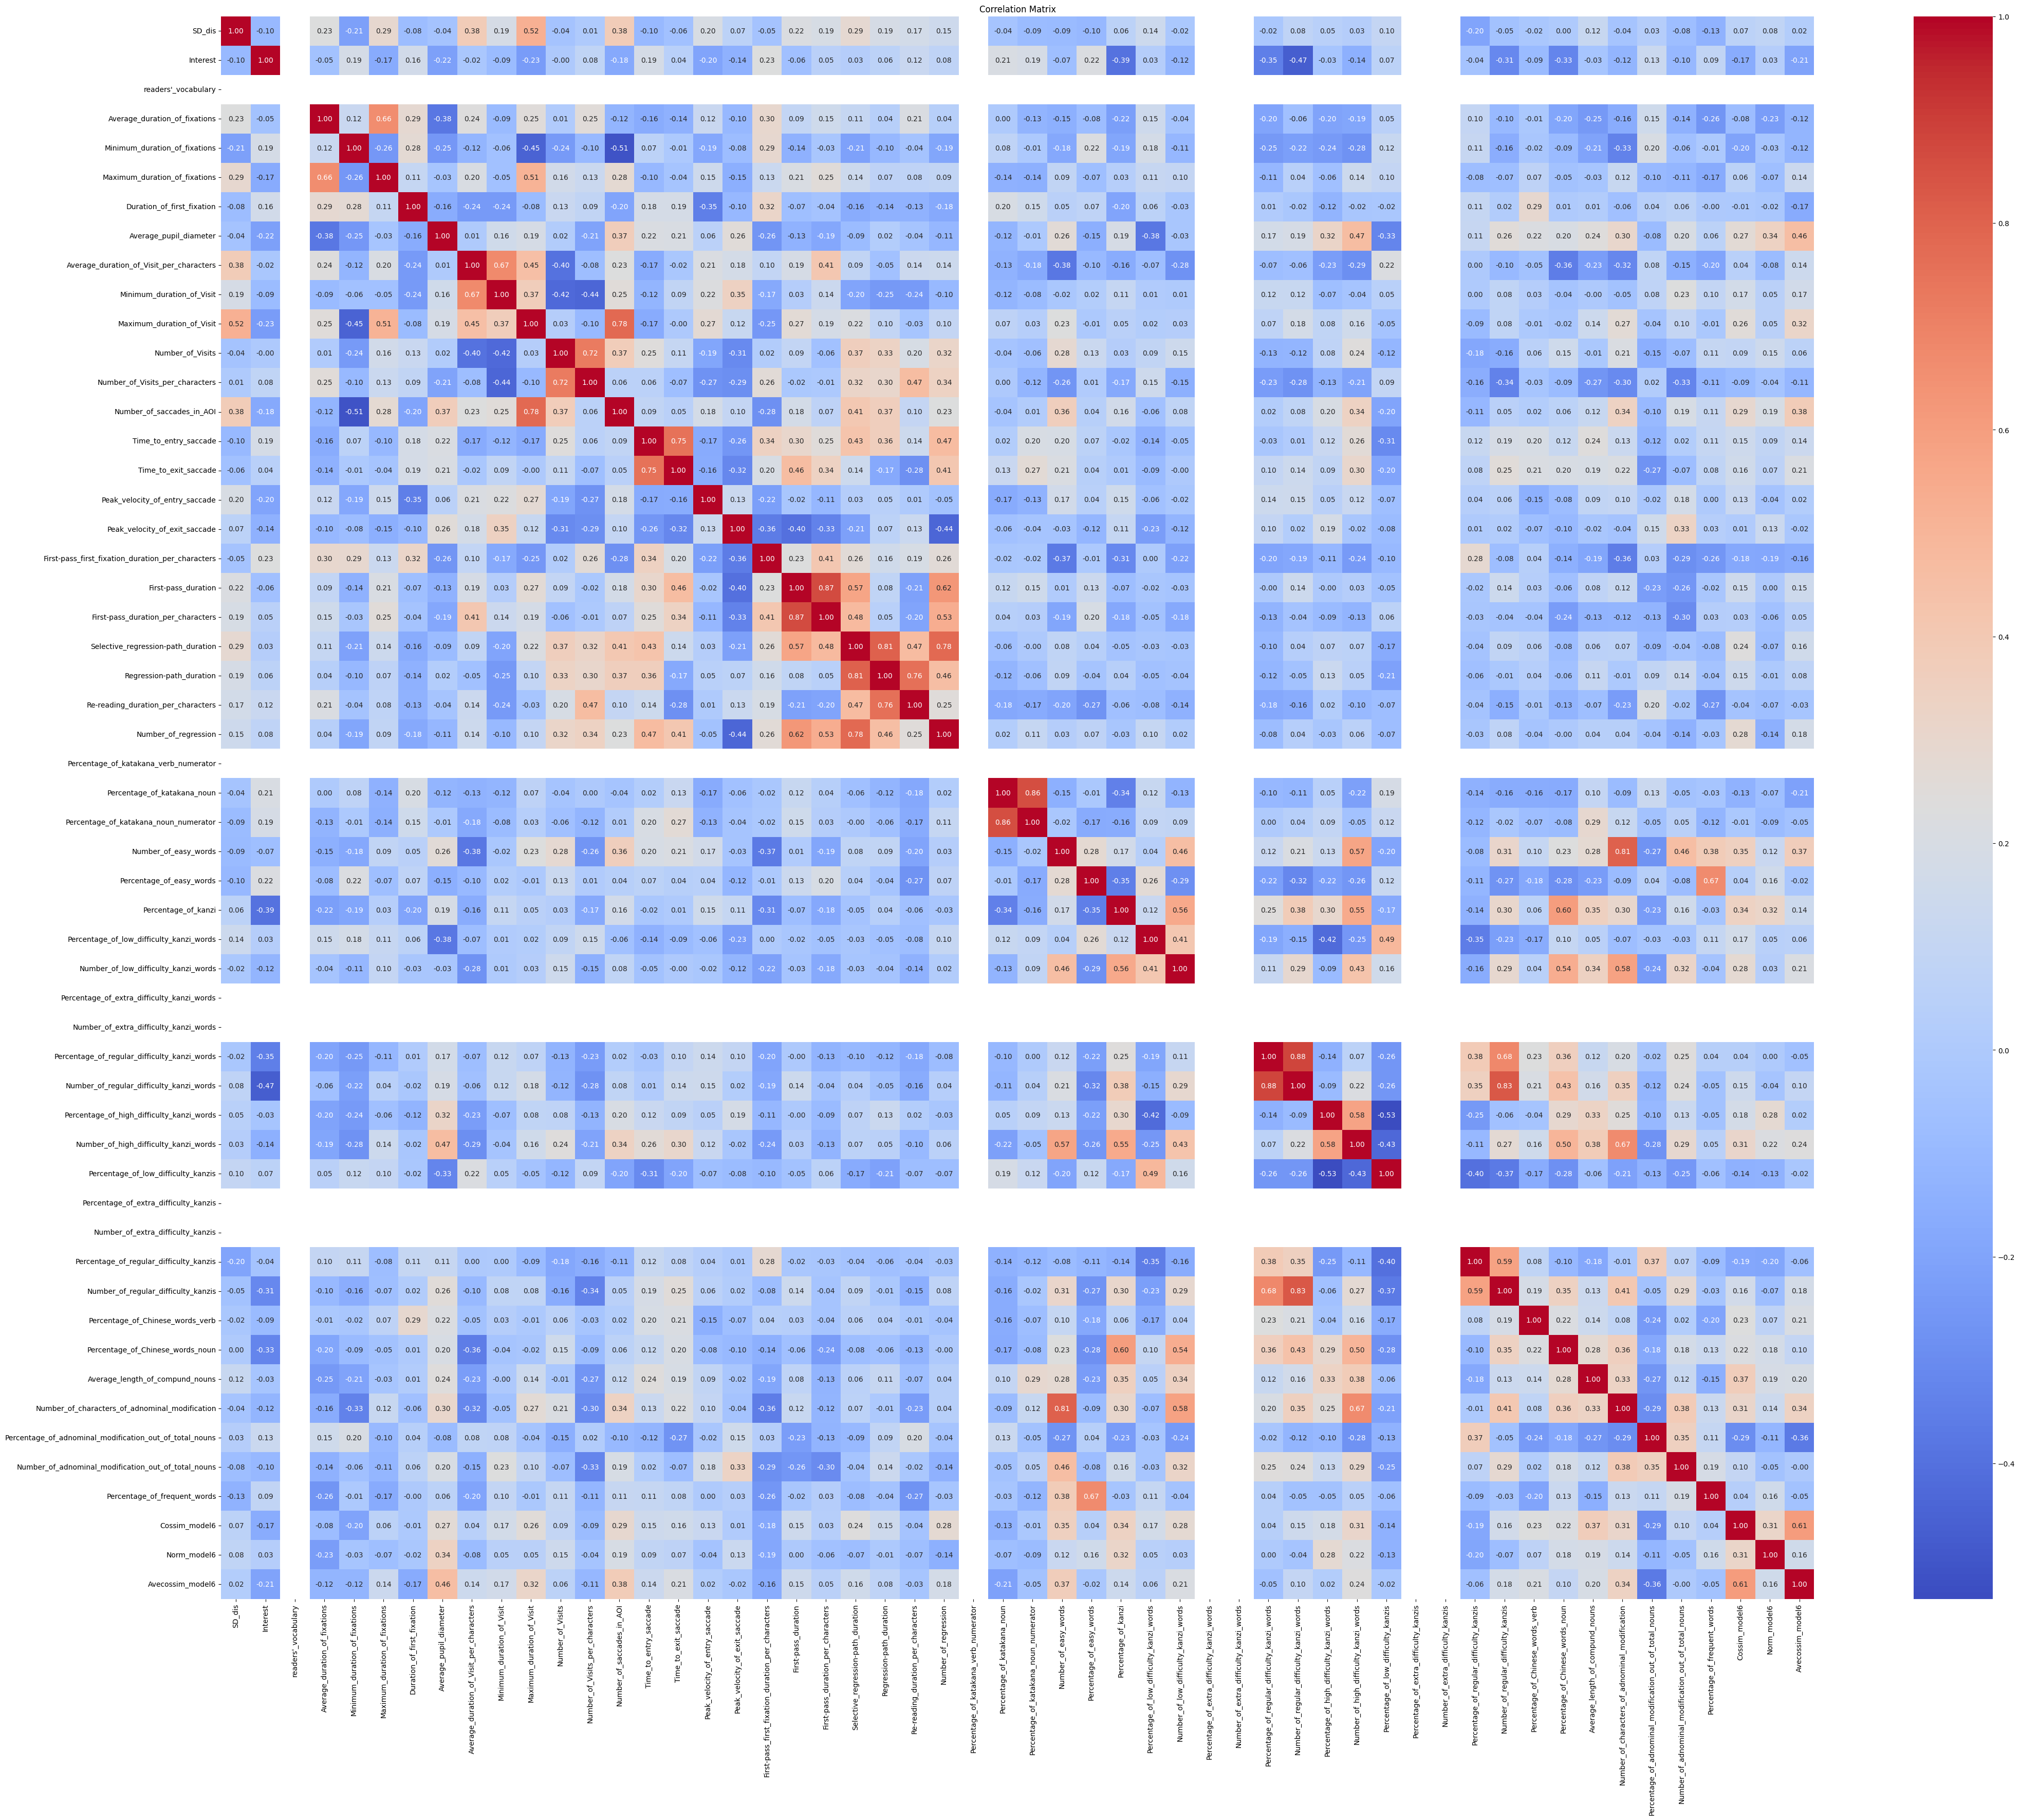

In [32]:
# データの可視化
plt.figure(figsize=(50, 40))
corr_matrix = data.corr('pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# # データの可視化
# plt.figure(figsize=(50, 40))
# corr_matrix = data.corr('spearman')
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title("Correlation Matrix")
# plt.show()

# # 散布図行列は時間かかるのでやりたいときだけ
# sns.pairplot(data)
# plt.title("Scatter Plot Matrix")
# plt.show()

In [33]:
# 特徴量選択
sfs = SFS(GradientBoostingClassifier(),
          k_features="best",
          forward = False,
          floating= True,
          scoring = 'accuracy',
          cv = 3,
          n_jobs= -1)

sfs = sfs.fit(X, y)

# 選択された特徴量の表示
selected_features = sfs.k_feature_names_
selected_features

('Interest',
 'Duration_of_first_fixation',
 'Minimum_duration_of_Visit',
 'Selective_regression-path_duration',
 'Number_of_regular_difficulty_kanzi_words',
 'Number_of_high_difficulty_kanzi_words',
 'Norm_model6')

In [34]:
# specific_feature = ['Maximum_duration_of_Visit',
#  'Peak_velocity_of_entry_saccade',
#  'First-pass_first_fixation_duration_per_characters',
#  'Percentage_of_katakana_noun',
#  'Percentage_of_extra_difficulty_kanzi_words',
#  'Number_of_regular_difficulty_kanzi_words',
#  'Number_of_extra_difficulty_kanzis',
#  'Cossim_model6']

# sfs_model = "None"

# type(specific_feature)

In [35]:
# selected_features = X.columns
# selected_features = specific_feature

# 選択された特徴量のみをXに指定
X_slected = X[list(selected_features)]
X_slected.head()

,Interest,Duration_of_first_fixation,Minimum_duration_of_Visit,Selective_regression-path_duration,Number_of_regular_difficulty_kanzi_words,Number_of_high_difficulty_kanzi_words,Norm_model6
468,0.319664,1.233670,-0.259795,-0.789928,-0.694088,-0.991550,-0.158592
469,0.319664,1.133351,1.815226,-0.789928,-0.694088,-0.343368,-0.241953
470,0.319664,1.033031,-0.503123,1.560825,0.958210,-0.343368,-0.786909
471,0.319664,2.401677,-0.524796,2.540751,-0.694088,-0.019277,-0.908325
472,0.319664,-0.794219,-0.513631,1.650314,-0.694088,-0.991550,0.052777


In [36]:
# 選択された特徴量でモデル構築
X_train, X_test, y_train, y_test = train_test_split(X_slected, y, test_size=0.2, random_state=42, stratify=y)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:

# モデルの構築
base_models = [
        ('log', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('svm', svm.SVC(kernel='rbf', probability=True, random_state=42)),
        ('knn', KNeighborsClassifier()),
        ('mlp', MLPClassifier(random_state=42)),
        ('nb', GaussianNB())
    ]

param_dist = {
    'log__penalty': ["l2"],
    'log__C': randint(1, 3),
    'log__solver': ['lbfgs', 'sag', 'liblinear'],
    'log__max_iter': randint(50, 150),
    'rf__n_estimators': randint(50, 150),
    'rf__criterion': ['gini', 'entropy', 'log_loss'],
    'rf__max_depth': randint(5, 50),
    'rf__min_samples_split': randint(1, 3),
    'rf__min_samples_leaf': uniform(0.01, 1),
    'gb__n_estimators':randint(80, 200),
    'gb__learning_rate': uniform(0.01, 0.3),
    'gb__max_depth':randint(3, 10),
    'gb__min_samples_leaf':randint(1, 5),
    'gb__subsample':uniform(0.5, 1.0),
    'svm__C': uniform(0.01, 100),
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'knn__n_neighbors':randint(2, 7),
    'knn__leaf_size':randint(10, 50),
    'mlp__hidden_layer_sizes': [(100,), (50,), (100, 50)],
    'mlp__alpha': uniform(0.0001, 0.01),
    'mlp__max_iter': randint(100, 300),
    'nb__var_smoothing': [1e-9, 5e-9, 1e-8],
    'final_estimator__C' : randint(1, 3),
    'final_estimator__max_iter' : randint(50, 150),
    'final_estimator__penalty' : ["l2"],
    'final_estimator__solver' : ['lbfgs', 'sag', 'liblinear']
}

meta_model = LogisticRegression(random_state=42)

stacking_model = StackingClassifier(estimators=base_models,
                                     final_estimator=meta_model,
                                       cv=5)


In [38]:
# ランダムサーチの実行
random_search = RandomizedSearchCV(estimator=stacking_model,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=3,
                                   scoring='accuracy',
                                   random_state=42)

random_search.fit(X_train_scaled, y_train)
print(random_search.best_params_)

c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (249) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (249) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (249) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (249) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_netw

{'final_estimator__C': 2, 'final_estimator__max_iter': 72, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'sag', 'gb__learning_rate': 0.1075549966080241, 'gb__max_depth': 5, 'gb__min_samples_leaf': 4, 'gb__n_estimators': 183, 'gb__subsample': 0.7747217929900642, 'knn__leaf_size': 44, 'knn__n_neighbors': 2, 'log__C': 1, 'log__max_iter': 96, 'log__penalty': 'l2', 'log__solver': 'sag', 'mlp__alpha': 0.008589138242660839, 'mlp__hidden_layer_sizes': (100,), 'mlp__max_iter': 241, 'nb__var_smoothing': 1e-08, 'rf__criterion': 'log_loss', 'rf__max_depth': 13, 'rf__min_samples_leaf': 0.7206628896857874, 'rf__min_samples_split': 2, 'rf__n_estimators': 91, 'svm__C': 43.94365018657701, 'svm__gamma': 0.01}


c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (241) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (241) reached and the optimization hasn't converged yet.
  warnings.warn(


In [39]:
# 最終モデルの構築
final_model = random_search.best_estimator_
final_model.fit(X_train_scaled, y_train)

c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (241) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (241) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (241) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (241) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_netw

StackingClassifier(cv=5,
                   estimators=[('log',
                                LogisticRegression(C=1, max_iter=96,
                                                   random_state=42,
                                                   solver='sag')),
                               ('rf',
                                RandomForestClassifier(criterion='log_loss',
                                                       max_depth=13,
                                                       min_samples_leaf=0.7206628896857874,
                                                       n_estimators=91,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.1075549966080241,
                                                           max_depth=5,
                                                           min_samples_leaf=4,
                                                           n_estimator...
                                                           subsample=0.7747217929900642)),
                               ('svm',
                                SVC(C=43.94365018657701, gamma=0.01,
                                    probability=True, random_state=42)),
                               ('knn',
                                KNeighborsClassifier(leaf_size=44,
                                                     n_neighbors=2)),
                               ('mlp',
                                MLPClassifier(alpha=0.008589138242660839,
                                              max_iter=241, random_state=42)),
                               ('nb', GaussianNB(var_smoothing=1e-08))],
                   final_estimator=LogisticRegression(C=2, max_iter=72,
                                                      random_state=42,
                                                      solver='sag'))

Accuracy: 0.7142857142857143
Precision: 0.8095238095238094
Recall: 0.7142857142857143
F1 Score: 0.6714285714285715


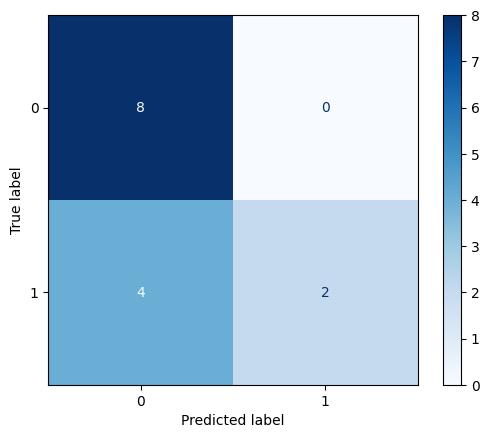

In [40]:
# 最終モデルのテストデータへの適用および性能評価
y_pred = final_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues')
plt.show()

In [41]:
# Compare base models
Model_accuracy = {}
for name, model in random_search.best_estimator_.estimators:
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    Model_accuracy[f"{name}"] = scores.mean()
    print(f"{name} Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Evaluate stacking model
stacking_scores = cross_val_score(final_model, X, y, cv=5, scoring='accuracy')
print(f"Stacking Model Accuracy: {stacking_scores.mean():.4f} (+/- {stacking_scores.std():.4f})")

c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


log Accuracy: 0.5571 (+/- 0.0286)


c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


rf Accuracy: 0.5571 (+/- 0.0286)
gb Accuracy: 0.6143 (+/- 0.0350)
svm Accuracy: 0.6000 (+/- 0.1604)
knn Accuracy: 0.6000 (+/- 0.1069)


c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (241) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (241) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (241) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


mlp Accuracy: 0.5714 (+/- 0.0639)
nb Accuracy: 0.6857 (+/- 0.0571)


c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: T

Stacking Model Accuracy: 0.6714 (+/- 0.0571)


c:\WorkSpace\Practice\env3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (241) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: log
  Interest: 0.0000
  Duration_of_first_fixation: 0.0214
  Minimum_duration_of_Visit: 0.1393
  Selective_regression-path_duration: 0.1929
  Number_of_regular_difficulty_kanzi_words: -0.0036
  Number_of_high_difficulty_kanzi_words: 0.0071
  Norm_model6: 0.0000
Model: rf
  Interest: 0.0000
  Duration_of_first_fixation: 0.0000
  Minimum_duration_of_Visit: 0.0000
  Selective_regression-path_duration: 0.0000
  Number_of_regular_difficulty_kanzi_words: 0.0000
  Number_of_high_difficulty_kanzi_words: 0.0000
  Norm_model6: 0.0000
Model: gb
  Interest: 0.0000
  Duration_of_first_fixation: 0.3107
  Minimum_duration_of_Visit: 0.0393
  Selective_regression-path_duration: 0.1929
  Number_of_regular_difficulty_kanzi_words: 0.0000
  Number_of_high_difficulty_kanzi_words: 0.0786
  Norm_model6: 0.0286
Model: svm
  Interest: 0.0036
  Duration_of_first_fixation: 0.2000
  Minimum_duration_of_Visit: 0.1071
  Selective_regression-path_duration: 0.1679
  Number_of_regular_difficulty_kanzi_words: 0.

100%|██████████| 56/56 [00:01<00:00, 42.45it/s]


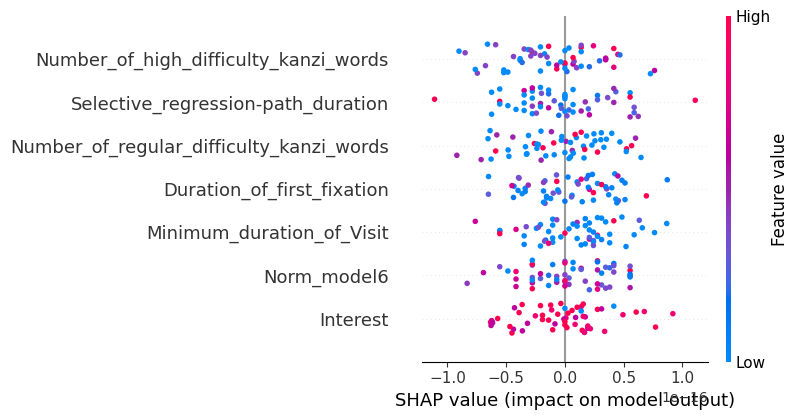

100%|██████████| 56/56 [00:01<00:00, 30.84it/s]


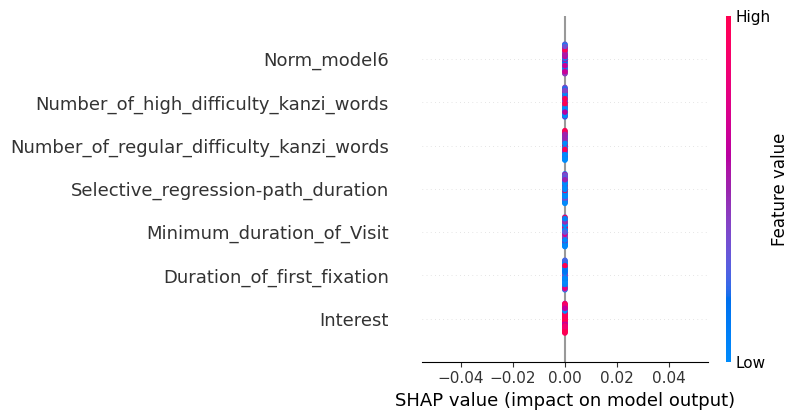

100%|██████████| 56/56 [00:01<00:00, 30.70it/s]


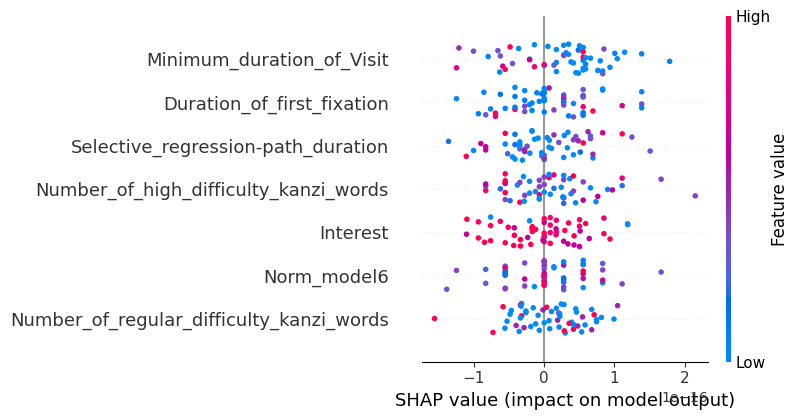

100%|██████████| 56/56 [00:02<00:00, 21.28it/s]


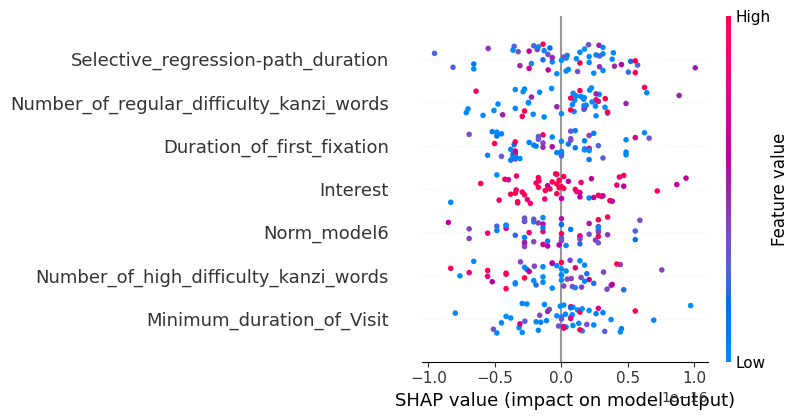

100%|██████████| 56/56 [00:01<00:00, 35.95it/s]


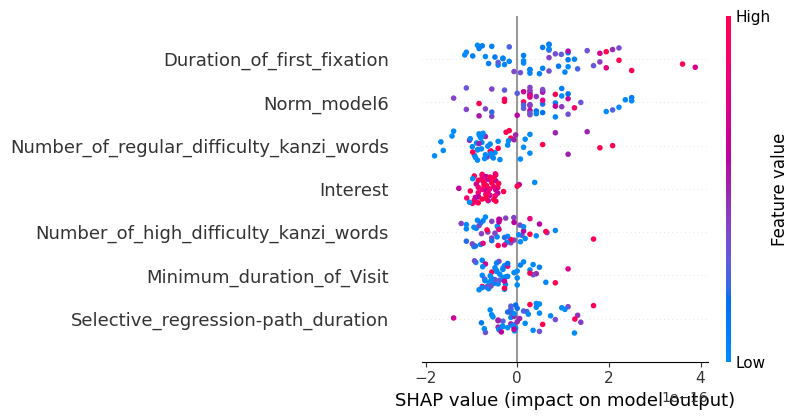

100%|██████████| 56/56 [00:01<00:00, 38.33it/s]


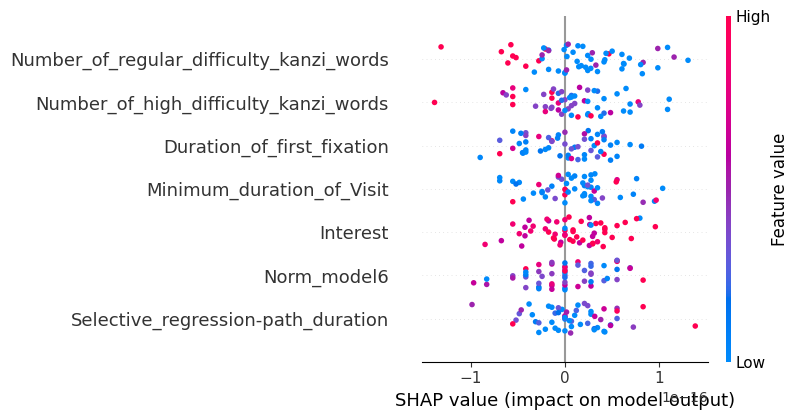

100%|██████████| 56/56 [00:01<00:00, 40.82it/s]


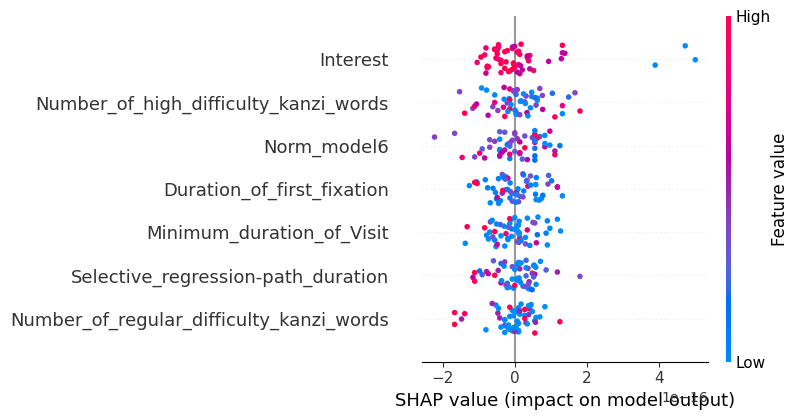

Model log
  Interest: -2.4433270387084045e-18
  Duration_of_first_fixation: 4.767010673617139e-18
  Minimum_duration_of_Visit: 8.023096076392733e-18
  Selective_regression-path_duration: -2.9428344681749406e-18
  Number_of_regular_difficulty_kanzi_words: -3.903127820947816e-18
  Number_of_high_difficulty_kanzi_words: -9.819773962225854e-18
  Norm_model6: 3.841173411091502e-18
Model rf
  Interest: 0.0
  Duration_of_first_fixation: 0.0
  Minimum_duration_of_Visit: 0.0
  Selective_regression-path_duration: 0.0
  Number_of_regular_difficulty_kanzi_words: 0.0
  Number_of_high_difficulty_kanzi_words: 0.0
  Norm_model6: 0.0
Model gb
  Interest: -1.634047559960296e-18
  Duration_of_first_fixation: 7.82174424435971e-18
  Minimum_duration_of_Visit: 2.337230111829466e-17
  Selective_regression-path_duration: 2.6802542545261075e-20
  Number_of_regular_difficulty_kanzi_words: 8.73557178974035e-18
  Number_of_high_difficulty_kanzi_words: 1.0439318060789e-17
  Norm_model6: 3.469446951953614e-18
Model

In [42]:
# 各モデルの特徴量重要度をPFIとSHAPで算出
from sklearn.inspection import permutation_importance
import shap

# 訓練データ(X_train, y_train)を用いてモデルをフィットします
for name, model in random_search.best_estimator_.estimators:
    model.fit(X_train, y_train)

PFIs = {}
for name, model in random_search.best_estimator_.estimators:
    pfi = permutation_importance(model, X_train, y_train, random_state=42)
    # 特徴量の名前と重要度をセットにした辞書を作成
    feature_importances = {X_train.columns[i]: pfi.importances_mean[i] for i in range(len(X_train.columns))}
    PFIs[f'{name}'] = feature_importances

# 結果の確認
for model_name, importances in PFIs.items():
    print(f"Model: {model_name}")
    for feature, importance in importances.items():
        print(f"  {feature}: {importance:.4f}")


SHAPs = {}
for name, model in random_search.best_estimator_.estimators:
    explainer = shap.KernelExplainer(model.predict_proba, X_train_scaled)
    shap_values = explainer.shap_values(X_train_scaled)
    shap_importances = np.mean(shap_values, axis=(0, 2))
    shaps = {X_train.columns[i]: shap_importances[i] for i in range(len(X_train.columns))}
    # SHAPs[f'{name}'] = np.mean(shap_values, axis=(0, 2))
    shap.summary_plot(np.mean(shap_values, axis=2), X_train_scaled, feature_names=selected_features)
    SHAPs[f'{name}'] = shaps

# 結果を表示
for model_name, importances in SHAPs.items():
    print(f"Model {model_name}")
    for feature, importance in importances.items():
        print(f"  {feature}: {importance}") 


In [43]:
""" # グラフプロット用の関数
def plot_feature_importance(Model):
    for model_name, features in Model.items():
        plt.figure(figsize=(10, 6))
        names, values = zip(*sorted(features.items(), key=lambda x: x[1], reverse=True))
        plt.barh(names, values, color='skyblue')
        plt.title(f"Feature Importance for Model: {model_name}")
        plt.xlabel("Permutation Importance")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()

# グラフ描画
plot_feature_importance(PFIs) """


' # グラフプロット用の関数\ndef plot_feature_importance(Model):\n    for model_name, features in Model.items():\n        plt.figure(figsize=(10, 6))\n        names, values = zip(*sorted(features.items(), key=lambda x: x[1], reverse=True))\n        plt.barh(names, values, color=\'skyblue\')\n        plt.title(f"Feature Importance for Model: {model_name}")\n        plt.xlabel("Permutation Importance")\n        plt.ylabel("Features")\n        plt.tight_layout()\n        plt.show()\n\n# グラフ描画\nplot_feature_importance(PFIs) '

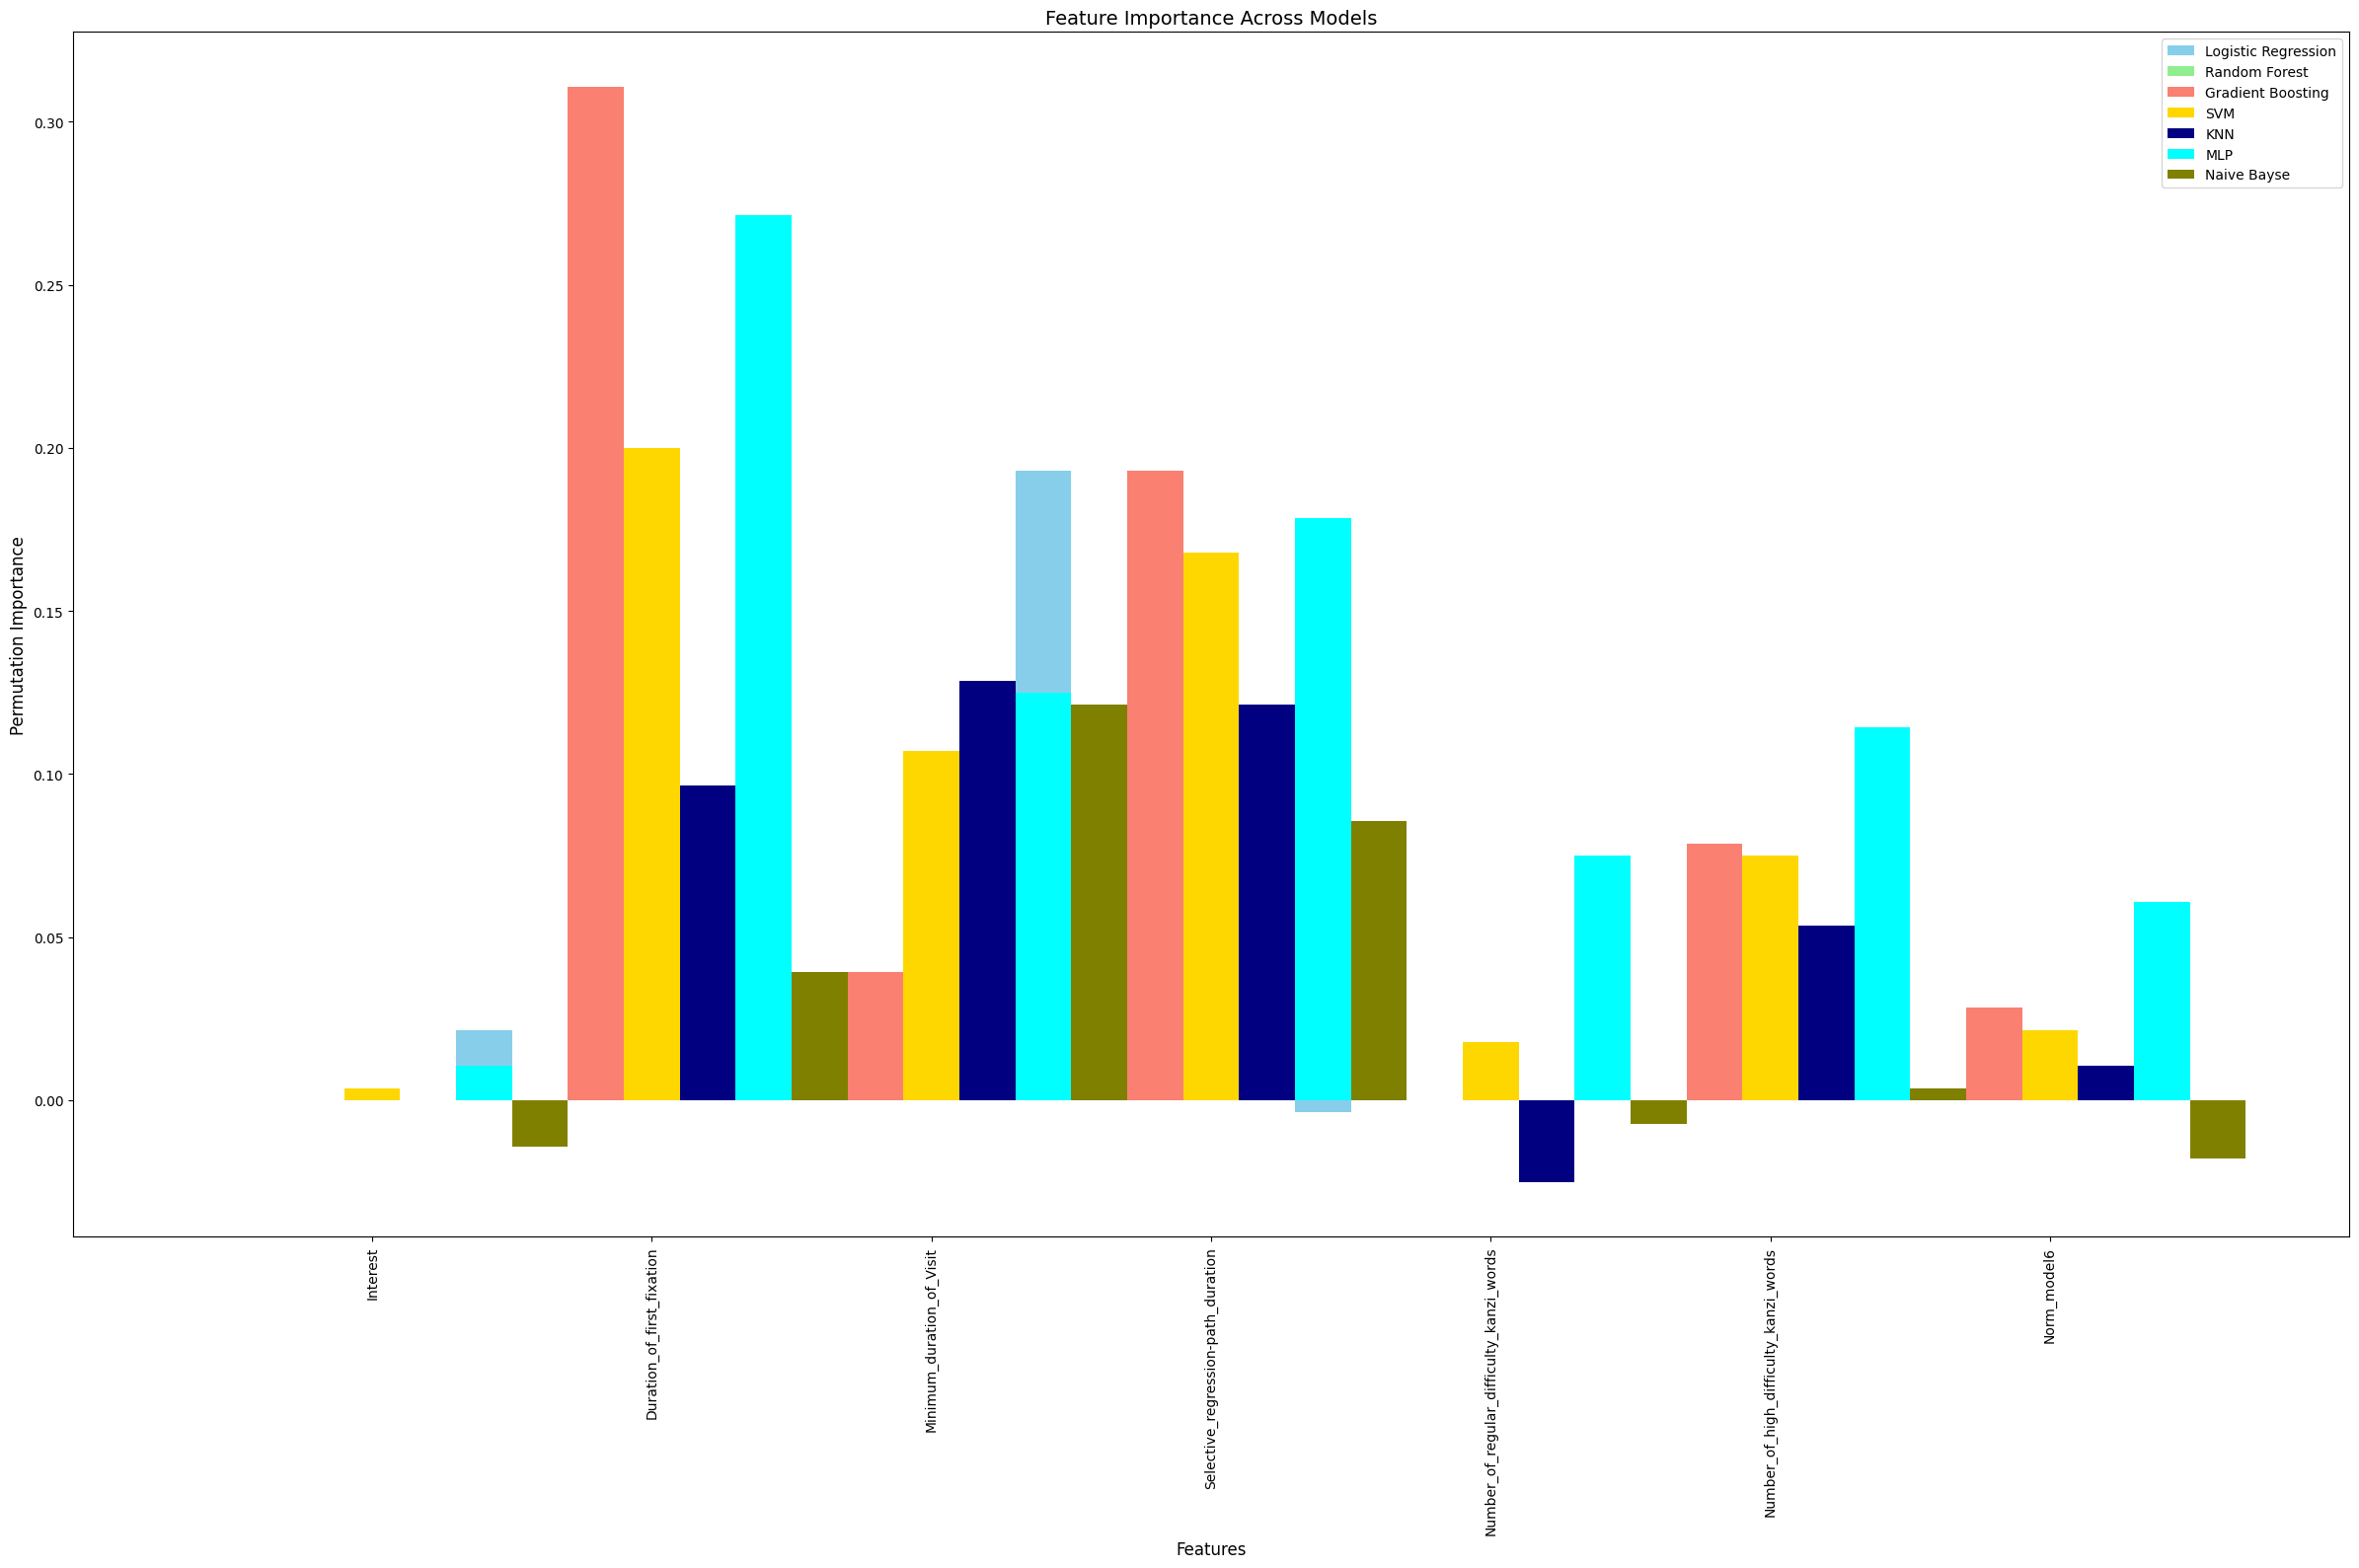

In [44]:
# 各モデルのデータを取得し、共通する特徴量リストを取得
features = list(PFIs["log"].keys())
importance_log = [PFIs["log"].get(f, 0) for f in features]
importance_rf = [PFIs["rf"].get(f, 0) for f in features]
importance_gb = [PFIs["gb"].get(f, 0) for f in features]
importance_svm = [PFIs["svm"].get(f, 0) for f in features]
importance_knn = [PFIs["knn"].get(f, 0) for f in features]
importance_mlp = [PFIs["mlp"].get(f, 0) for f in features]
importance_nb = [PFIs["nb"].get(f, 0) for f in features]

# グラフ描画
x = np.arange(len(features))  # 各特徴量の位置
width = 0.2  # バーの幅

fig, ax = plt.subplots(figsize=(12*2, 8*2))

# 各モデルの棒グラフをプロット
ax.bar(x - 3*width, importance_log, width, label='Logistic Regression', color='skyblue')
ax.bar(x - 2*width, importance_rf, width, label='Random Forest', color='lightgreen')
ax.bar(x - width, importance_gb, width, label='Gradient Boosting', color='salmon')
ax.bar(x, importance_svm, width, label='SVM', color='gold')
ax.bar(x + width, importance_knn, width, label='KNN', color='navy')
ax.bar(x + 2*width, importance_mlp, width, label='MLP', color='aqua')
ax.bar(x + 3*width, importance_nb, width, label='Naive Bayse', color='olive')

# 軸ラベルや目盛設定
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Permutation Importance', fontsize=12)
ax.set_title('Feature Importance Across Models', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90, fontsize=10)
ax.legend()

plt.tight_layout()
plt.show()

In [45]:
# # 結果の記録
# basemodel_names = [name for name, _ in base_models]

# import datetime
# currenttime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# """ Accuracy = accuracy_score(y_test, y_pred)
# Precision = precision_score(y_test, y_pred, average='weighted')
# Recall = recall_score(y_test, y_pred, average='weighted')
# F1_Score = f1_score(y_test, y_pred, average='weighted') """

# model_list = random_search.best_estimator_.estimators
# Models = {}
# for name, _ in model_list:
#     Models[f"{name}"] = f"{name}"



# result = {'Original Data shape': [X.shape],
#             'sfs_model' : [sfs_model],
#             'Models': [basemodel_names],
#             'Best number of features': len(sfs.k_feature_idx_),
#             'Slected Features': [selected_features],
#             'Model Params':[random_search.best_params_],
#             'Accuracy': accuracy_score(y_test, y_pred),
#             'Precision': precision_score(y_test, y_pred, average='weighted'),
#             'Recall': recall_score(y_test, y_pred, average='weighted'),
#             'F1_Score' : f1_score(y_test, y_pred, average='weighted'),
#             'Date': currenttime,
#             'Dataset' : file_path
#             }

# save_importances = {
#                     'model' : Models,
#                     'PFI' : PFIs,
#                     # 'SHAP' : SHAPs,
#                     'Date': currenttime
#                     }

# new_result = pd.DataFrame(result)
# new_result.to_csv('C:/WorkSpace/Practice/卒研B/result2.csv',
#                   mode='a',
#                   header=False,
#                   index=False)

# new_importances = pd.DataFrame(save_importances)
# new_importances.to_csv('C:/WorkSpace/Practice/卒研B/importances.csv',
#                   mode='a',
#                   header=True,
#                   index=False)

In [46]:
# 結果の記録
basemodel_names = [name for name, _ in base_models]

import datetime
currenttime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

""" Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred, average='weighted')
Recall = recall_score(y_test, y_pred, average='weighted')
F1_Score = f1_score(y_test, y_pred, average='weighted') """

model_list = random_search.best_estimator_.estimators
Models = {}
for name, _ in model_list:
    Models[f"{name}"] = f"{name}"



result = {'Original Data shape': [X.shape],
            'sfs' : sfs,
            'Models': [basemodel_names],
            'Best number of features': len(selected_features),
            'Slected Features': [selected_features],
            'Model Params':[random_search.best_params_],
            'Model Accuravy':[Model_accuracy],
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1_Score' : f1_score(y_test, y_pred, average='weighted'),
            'Date': currenttime,
            'Dataset' : file_path
            }

save_importances = {
                    'model' : Models,
                    'PFI' : PFIs,
                    'SHAP' : SHAPs,
                    'Date': currenttime
                    }

new_result = pd.DataFrame(result)
new_result.to_csv('C:/WorkSpace/Practice/卒研B/result4.csv',
                  mode='a',
                  header=False,
                  index=False)

new_importances = pd.DataFrame(save_importances)
new_importances.to_csv('C:/WorkSpace/Practice/卒研B/importances4.csv',
                  mode='a',
                  header=True,
                  index=False)

In [47]:
random_search.best_estimator_.estimators

[('log', LogisticRegression(C=1, max_iter=96, random_state=42, solver='sag')),
 ('rf',
  RandomForestClassifier(criterion='log_loss', max_depth=13,
                         min_samples_leaf=0.7206628896857874, n_estimators=91,
                         random_state=42)),
 ('gb',
  GradientBoostingClassifier(learning_rate=0.1075549966080241, max_depth=5,
                             min_samples_leaf=4, n_estimators=183,
                             random_state=42, subsample=0.7747217929900642)),
 ('svm',
  SVC(C=43.94365018657701, gamma=0.01, probability=True, random_state=42)),
 ('knn', KNeighborsClassifier(leaf_size=44, n_neighbors=2)),
 ('mlp',
  MLPClassifier(alpha=0.008589138242660839, max_iter=241, random_state=42)),
 ('nb', GaussianNB(var_smoothing=1e-08))]

In [48]:
import time
for i in range(5):
    print(i)
    time.sleep(1)
!rundll32 user32.dll,MessageBeep

0
1
2
3
4
